In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
### carga datos de dataset en dataframe
file_path= 'uber_fares.csv'

df = pd.read_csv(file_path)

In [4]:
### visualizacion de algunos datos
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


#### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

In [5]:
### Columnas, ¿cuáles son variables numéricas y cuales variables categóricas?
df.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


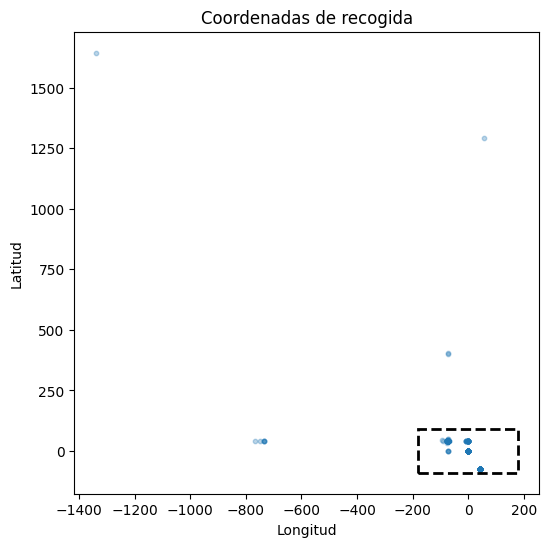

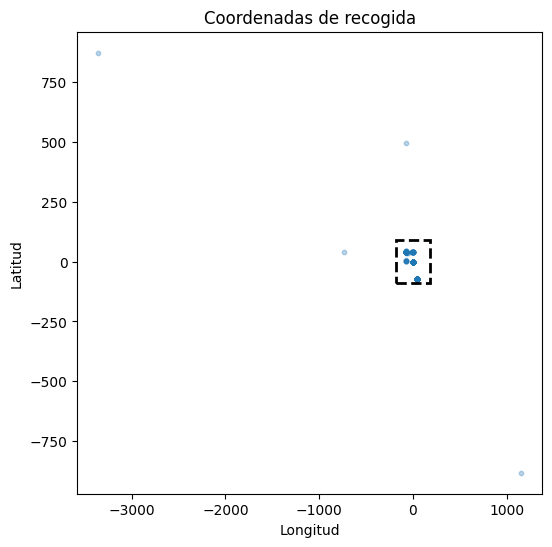

In [7]:
#Coordenadas de Pickup
plt.figure(figsize=(6,6))
plt.scatter(df["pickup_longitude"], df["pickup_latitude"], s=10, alpha=0.3)

world_rect = patches.Rectangle(
    (-180, -90),  
    360,          
    180,           
    linewidth=2, edgecolor='black', facecolor='none', linestyle='--'
)
plt.gca().add_patch(world_rect)

plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Coordenadas de recogida")
plt.show()

#Coordenadas de Dropoff
plt.figure(figsize=(6,6))
plt.scatter(df["dropoff_longitude"], df["dropoff_latitude"], s=10, alpha=0.3)

world_rect = patches.Rectangle(
    (-180, -90),  
    360,          
    180,           
    linewidth=2, edgecolor='black', facecolor='none', linestyle='--'
)
plt.gca().add_patch(world_rect)

plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Coordenadas de recogida")
plt.show()


***JUSTIFICACION DE POR QUE DROPEAMOS COORDENADAS INVALIDAS***

Primero validamos las coordenadas para evitar que valores inválidos generen distancias absurdas. Incluso dentro del rango [-90,90]/[-180,180]

In [ ]:
#Coordenadas reales
lat_min, lat_max = -90, 90  
lon_min, lon_max = -180, 180

valid_pickup_lat = df["pickup_latitude"].between(lat_min, lat_max)
valid_pickup_lon = df["pickup_longitude"].between(lon_min, lon_max)
valid_dropoff_lat = df["dropoff_latitude"].between(lat_min, lat_max)
valid_dropoff_lon = df["dropoff_longitude"].between(lon_min, lon_max)

invalid_counts = (
    (~valid_pickup_lat).astype(int) +
    (~valid_pickup_lon).astype(int) +
    (~valid_dropoff_lat).astype(int) +
    (~valid_dropoff_lon).astype(int)
)

#Dropeamos filas con más de 1 coordenada inválida
df_filtrado = df[invalid_counts <= 1]
df_filtrado

#Reemplazamos las coordenadas inválidas con NaN
df_filtrado.loc[~valid_pickup_lat, "pickup_latitude"] = np.nan
df_filtrado.loc[~valid_pickup_lon, "pickup_longitude"] = np.nan
df_filtrado.loc[~valid_dropoff_lat, "dropoff_latitude"] = np.nan
df_filtrado.loc[~valid_dropoff_lon, "dropoff_longitude"] = np.nan
df_filtrado.isna().sum()

 

key                  0
date                 0
fare_amount          0
pickup_datetime      0
pickup_longitude     6
pickup_latitude      2
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_filtrado.drop(columns='fare_amount'), df_filtrado['fare_amount'], test_size=0.2, random_state=42)


<Axes: xlabel='distance_km'>

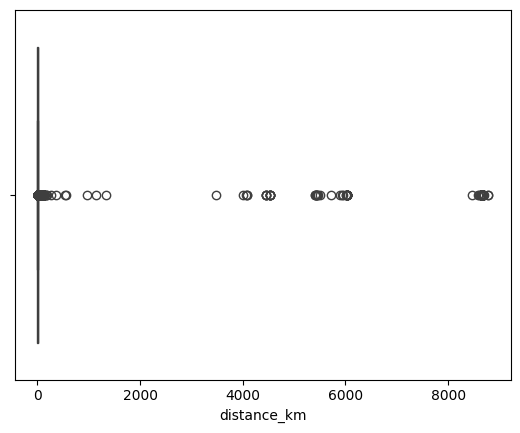

In [ ]:
def haversine_km(lat1, lon1, lat2, lon2):
    # retorna distancia en kilómetros (vectorizado)
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c


X_train_copy = X_train[coord].copy()

X_train_copy['distance_km'] = haversine_km(
    X_train_copy['pickup_latitude'], X_train_copy['pickup_longitude'],
    X_train_copy['dropoff_latitude'], X_train_copy['dropoff_longitude']
)

X_train_copy['distance_km'].describe()
sns.boxplot(x=X_train_copy['distance_km'])


In [ ]:

# --- Seleccionamos la columna ---
distancias = X_train_copy["distance_km"]

# --- Cuartiles ---
Q1 = np.percentile(distancias, 25)
Q3 = np.percentile(distancias, 75)

# --- Rango intercuartílico (IQR) ---
IQR = Q3 - Q1

# --- Bigotes ---
bigote_inferior = Q1 - 1.5 * IQR
bigote_superior = Q3 + 1.5 * IQR

# --- Resultados ---
print(f"Q1: {Q1:.2f}")
print(f"Q3: {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"Bigote inferior: {bigote_inferior:.2f}")
print(f"Bigote superior: {bigote_superior:.2f}")

# --- Opcional: detectar outliers ---
outliers = distancias[(distancias > bigote_superior)]
print(f"Cantidad de outliers: {len(outliers)}")


### Determinar que rango de km vamos a considerar como outliers¿¿¿¿

Q1: 1.22
Q3: 3.87
IQR: 2.66
Bigote inferior: -2.77
Bigote superior: 7.86
Cantidad de outliers: 13388


***AGREGAR JUSTIFICACION DE QUE VAMOS A HACER CON EL OUTLIER***
No eliminamos filas innecesariamente y no inventamos datos arbitrarios. Usamos la moda porque refleja el valor más frecuente y es consistente con la realidad del dominio (viajes de 1 pasajero).

In [ ]:
X_train[X_train["dropoff_latitude"].isnull()]
X_train["dropoff_longitude"][X_train["dropoff_longitude"].isnull()]

,key,date,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
87946,32736015,2013-07-02 03:51:57.0000001,2013-07-02 03:51:57 UTC,-73.950581,40.779692,NaN,NaN,0


***AGREGAR JUSTIFICACION DE QUE VAMOS A HACER CON NULOS***


Porcentaje de valores negativos sobre el total de registros en y_train: 0.011875%


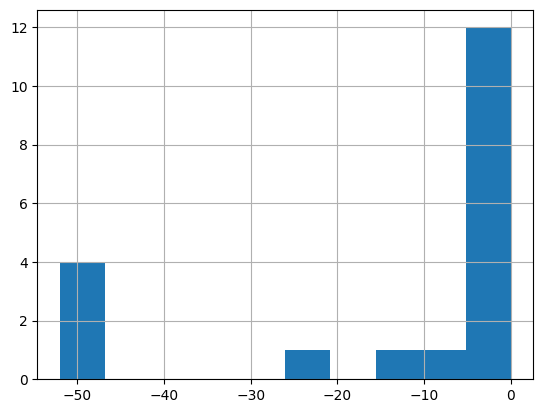

In [ ]:
y_train.isnull().sum() # no hay nulos en y_train
y_train[y_train <= 0].hist()
negativos = y_train[y_train <= 0].size
print(f"Porcentaje de valores negativos sobre el total de registros en y_train: {negativos / y_train.size * 100}%")  # porcentaje de negativos en y_train


***AGREGAR JUSTIFICACION DE QUE VAMOS A HACER CON NEGATIVOS***
(Puede que los saldos negativos signifiquen devoluciones y los 0 sean o por suscripciones-enlaces a otras aplicaciones, descuentos o algo de eso)
“El target es la variable dependiente. No podemos imputar ni corregir arbitrariamente su valor porque introduciríamos ruido o falsos patrones. Decidimos eliminar esas filas, que representan 0.01% del dataset, por ser inconsistentes con la realidad.” 
Eliminamos las observaciones con fare_amount <= 0 ya que no representan situaciones reales y no es posible imputarlas en la variable objetivo. Esto afectó al X% de los datos.

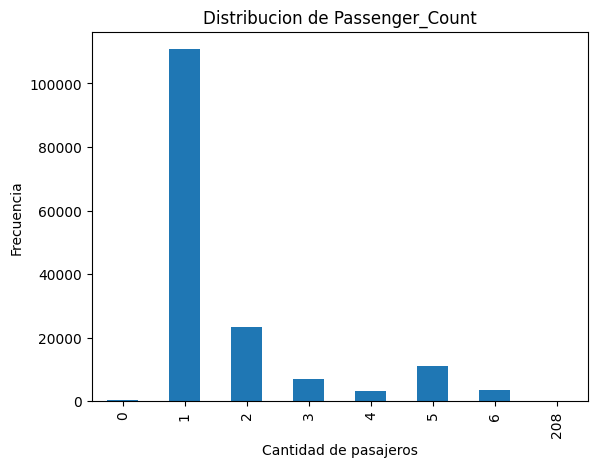

passenger_count
1      110730
2       23541
5       11227
3        7087
6        3423
4        3411
0         580
208         1
Name: count, dtype: int64

In [ ]:
X_train["passenger_count"].value_counts().sort_index().plot(kind='bar')
plt.title("Distribucion de Passenger_Count")
plt.xlabel("Cantidad de pasajeros")
plt.ylabel("Frecuencia")
plt.show()
X_train["passenger_count"].value_counts()


### COMMIT SEBA